In [141]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt



In [142]:
X_test_full = pd.read_csv('./datas/X_test.csv')
y_test_full = pd.read_csv('./datas/Y_test.csv')

#Import des datas train
X_train_full = pd.read_csv('./datas/X_train.csv')
Y_train_full = pd.read_csv('./datas/y_train.csv')

#df_X_train.head()
X_train_full.columns

Index(['DELIVERY_START', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nucelear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std',
       'predicted_spot_price'],
      dtype='object')

In [143]:
Y_train_full.head()


,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907


In [144]:
print(Y_train_full.describe())
print(X_train_full.describe())

       spot_id_delta
count   10605.000000
mean        0.943358
std        38.093819
min     -1567.353547
25%       -11.934152
50%         0.059125
75%        12.190489
max       658.961329
       load_forecast  coal_power_available  gas_power_available  \
count    9318.000000          10604.000000         10604.000000   
mean    53725.132968           2819.781592         11463.220671   
std     11274.194929            495.103588           483.799154   
min     30515.000000           1646.000000          9769.000000   
25%     45336.500000           2226.000000         11140.000000   
50%     51846.000000           2806.000000         11487.000000   
75%     62091.750000           3386.000000         11945.000000   
max     85145.000000           3391.000000         11963.000000   

       nucelear_power_available  wind_power_forecasts_average  \
count              10604.000000                  10581.000000   
mean               35393.282252                   4512.989415   
std         

In [145]:
print(Y_train_full.info())
print(X_train_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DELIVERY_START  10605 non-null  object 
 1   spot_id_delta   10605 non-null  float64
dtypes: float64(1), object(1)
memory usage: 165.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nucelear_power_available       10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7  

In [146]:
print(X_train_full['predicted_spot_price'])
X_train_full.to_excel('X_train_test.xlsx', index=False)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
10600    108.11
10601    125.66
10602    138.01
10603    136.74
10604    120.32
Name: predicted_spot_price, Length: 10605, dtype: float64


# Elastic_Net

In [147]:
target_column = 'predicted_spot_price' #variable intérêt
feature_columns = [col for col in X_train_full.columns if col != target_column and col != 'DELIVERY_START'] #features

In [148]:
# Séparation : lignes avec valeurs connues pour entraînement, lignes avec NaN pour imputation
train_mask = ~X_train_full[target_column].isna()
impute_mask = X_train_full[target_column].isna()

# Données d'entraînement
X_train = X_train_full.loc[train_mask, feature_columns]
y_train = X_train_full.loc[train_mask, target_column]

In [149]:
X_impute = X_train_full.loc[impute_mask, feature_columns]

print(len(X_train)) #nb ligne entraînement
print(len(X_impute))

1846
8759


In [150]:
imputer_features = SimpleImputer(strategy='mean')
X_train_imputed = imputer_features.fit_transform(X_train)
X_impute_imputed = imputer_features.transform(X_impute)

In [151]:
#Standardisation des valeurs, important pour Elastic Net !!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_impute_scaled = scaler.transform(X_impute_imputed)

In [152]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

grid_search = GridSearchCV(
    ElasticNet(max_iter=10000, random_state=42),
    param_grid,
    cv=5, #validation divisé en 5 parties cross validation
    scoring='neg_mean_squared_error', #erreur quatradique moyenne négative comme scoring
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Afficher les meilleurs paramètres
print(grid_search.best_params_)

{'alpha': 0.1, 'l1_ratio': 0.5}


In [153]:
best_elastic_net = grid_search.best_estimator_

# 7. Imputer les valeurs manquantes
imputed_values = best_elastic_net.predict(X_impute_scaled)

X_train_full_imputed = X_train_full.copy()
X_train_full_imputed.loc[impute_mask, target_column] = imputed_values

X_train_full_imputed.to_csv('X_train_imputed.csv', index=False)

In [154]:
cv_scores = cross_val_score(
    best_elastic_net,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

print(f"RMSE moyen (validation croisée): {np.sqrt(-cv_scores.mean()):.4f}")

RMSE moyen (validation croisée): 17.6705


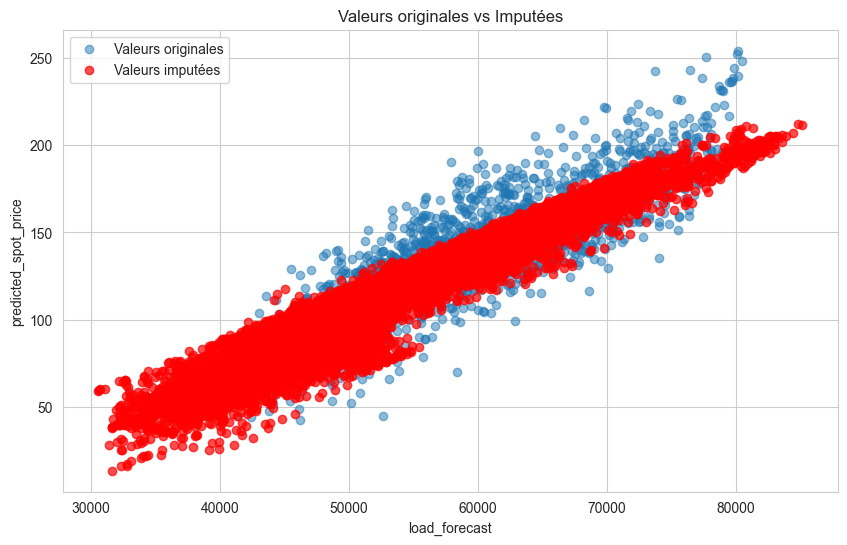

In [155]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_full.loc[train_mask, 'load_forecast'],
            X_train_full.loc[train_mask, target_column],
            alpha=0.5,
            label='Valeurs originales')
plt.scatter(X_train_full.loc[impute_mask, 'load_forecast'],
            imputed_values,
            color='red',
            alpha=0.7,
            label='Valeurs imputées')
plt.xlabel('load_forecast')
plt.ylabel(target_column)
plt.title('Valeurs originales vs Imputées')
plt.legend()
plt.show()

In [156]:
print("\nStatistiques des valeurs originales:")
print(X_train_full.loc[train_mask, target_column].describe())



Statistiques des valeurs originales:
count    1846.000000
mean      140.256024
std        33.922669
min        42.420000
25%       119.405000
50%       140.040000
75%       160.765000
max       254.190000
Name: predicted_spot_price, dtype: float64


In [157]:
print("\nStatistiques des valeurs imputées:")
print(pd.Series(imputed_values).describe())


Statistiques des valeurs imputées:
count    8759.000000
mean      109.855493
std        37.428983
min        13.551147
25%        80.760127
50%       110.843822
75%       133.737231
max       212.134066
dtype: float64
